In [23]:
import sys
sys.path.append('../')
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
from archived.seq2seq.model_seq2seq import *
from utils import Doc, read
from attribute import TFIDFKeywordExtractor

In [24]:
dev_lyrics = read()[:500]
Doc.load_corpus(dev_lyrics)

0.00% Loaded.
10.00% Loaded.
20.00% Loaded.
30.00% Loaded.
40.00% Loaded.
50.00% Loaded.
60.00% Loaded.
70.00% Loaded.
80.00% Loaded.
90.00% Loaded.
Loading complete
Filtering out rare words.
including the special words into vocab dict.
Complete 
Vocab size 10000
Filtered 0.00% too short or too many unks.


In [25]:
# Doc.text_to_idxs("EOS_token")
len(Doc.get_vocab())
Doc.text_to_idxs("一万")
Doc.idxs_to_text(np.array([2]))

'PAD_token'

In [4]:
special_words = {
    "SOS_token": 0,
    "EOS_token": 1,
    "PAD_token": 2
                }
# a = Doc.get_vocab()

In [5]:
Doc.load()
list_of_list_of_lines = [doc.get_lines() for doc in Doc.get_corpus()]
e = TFIDFKeywordExtractor(list_of_list_of_lines, len(Doc.get_vocab()))
#e.get_keywords()

In [6]:
text_sample = list_of_list_of_lines
# print(Doc.idxs_to_text(text_sample[0]))
keywords = TFIDFKeywordExtractor(text_sample, len(Doc.get_vocab()),n_keywords = 3)
keywords.get_keywords()
pairs = list(zip([i for j in keywords.get_keywords() for i in j],\
            [i for j in text_sample for i in j]))

In [7]:
hidden_size = 512
teacher_forcing_ratio = 0.5
MIN_LENGTH = 0
MAX_LENGTH = 40
BATCH_SIZE = 32
SOS_token = 0
EOS_token = 1
PAD_token = 2



use_cuda = torch.cuda.is_available()

def keywords_filterPair(p):
    return MIN_LENGTH < len(p[0]) < MAX_LENGTH and \
        MIN_LENGTH < len(p[1]) < MAX_LENGTH

def keywords_filterPairs(pairs):
    return [pair for pair in pairs if keywords_filterPair(pair)]

In [8]:
filtered_pairs = keywords_filterPairs(pairs)

In [9]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [10]:
from sklearn.cross_validation import train_test_split
train_input,val_input, _, __ =  \
    train_test_split(filtered_pairs,np.zeros(np.array(filtered_pairs).shape),test_size=0.2, random_state=0)
    

/home/jinxingyu/anaconda2/envs/lyrics/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [11]:
def earlystopping(loss_list, patience):
    if len(loss_list)> patience:
        loss_diff = np.array(loss_list[1:]) - np.array(loss_list[:-1])
        if loss_diff[(-1)*patience:].all() > 0:
            return True
    return False

In [12]:
def trainIters(encoder, decoder,train_input, val_input, n_iters = 2000, patience = 3, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_train_losses = []
    print_train_loss_total = 0  # Reset every print_every
    plot_train_loss_total = 0  # Reset every plot_every
    
    plot_val_losses = []
    print_val_loss_total = 0  # Reset every print_every
    plot_val_loss_total = 0  # Reset every plot_every
    

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pairs = [keywords_variablesFromPair(random.choice(train_input)) for i in range(BATCH_SIZE)]
        train_input_variable = torch.cat([pair[0] for pair in training_pairs], 1)
        train_target_variable = torch.cat([pair[1] for pair in training_pairs], 1)
        
        train_loss = train(train_input_variable, train_target_variable, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_train_loss_total += train_loss
        plot_train_loss_total += train_loss

        val_pairs = [keywords_variablesFromPair(random.choice(val_input)) for i in range(BATCH_SIZE)]
        val_input_variable = torch.cat([pair[0] for pair in val_pairs], 1)
        val_target_variable = torch.cat([pair[1] for pair in val_pairs], 1)
        val_loss = evaluate(val_input_variable, val_target_variable, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_val_loss_total += val_loss
        plot_val_loss_total += val_loss
        
        
        if iter % print_every == 0:
            print_train_loss_avg = print_train_loss_total / print_every
            print_train_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_train_loss_avg))
            print_val_loss_avg = print_val_loss_total / print_every
            print_val_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_val_loss_avg))

        if iter % plot_every == 0:
            plot_train_loss_avg = plot_train_loss_total / plot_every
            plot_train_losses.append(plot_train_loss_avg)
            plot_train_loss_total = 0
            
            plot_val_loss_avg = plot_val_loss_total / plot_every
            plot_val_losses.append(plot_val_loss_avg)
            plot_val_loss_total = 0
            if earlystopping(plot_val_losses, patience) == True:
                print("Training process stopped due to earlystopping with patience ", patience)
                break
            predictRandomly(encoder, decoder, val_input)
            showPlot(plot_train_losses,plot_val_losses)

In [13]:
def keywords_variableFromIndex(indexes, reverse=False):
    indexes = indexes.tolist()
    indexes.append(EOS_token)
    indexes = [PAD_token] * (MAX_LENGTH - len(indexes)) + indexes
    if reverse:
        indexes = indexes[::-1]
    result = Variable(torch.LongTensor(indexes).view(-1, 1))
    if use_cuda:
        return result.cuda()
    else:
        return result


def keywords_variablesFromPair(pair):
    input_variable = keywords_variableFromIndex(pair[0])
    target_variable = keywords_variableFromIndex(pair[1], False)
    return (input_variable, target_variable)

In [14]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points1, points2 = []):
#     plt.figure()
#     fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
#     loc = ticker.MultipleLocator(base=0.2)
#     ax.yaxis.set_major_locator(loc)
    plt.plot(points1)
    plt.plot(points2)
    plt.show()

In [15]:
def predict(encoder, decoder, input_variable, max_length=MAX_LENGTH, beam_width=30):
    input_length = len(input_variable)
    encoder_hidden = encoder.initHidden(beam_width)

    input_variable = torch.cat([input_variable for i in range(beam_width)], 1)

    encoder_outputs = Variable(torch.zeros(beam_width, max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei],
                                                 encoder_hidden)
        encoder_outputs[:, ei] = encoder_output[0]

    decoder_input = Variable(torch.LongTensor([[SOS_token]] * beam_width))  # SOS
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    decoder_hidden = encoder_hidden
    decoder_hidden_copy = Variable(torch.zeros(encoder1.n_layers, beam_width, hidden_size))
    decoder_hidden_copy = decoder_hidden_copy.cuda() if use_cuda else decoder_hidden_copy
    
    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)

    probability = torch.zeros(beam_width).view(-1, 1)
    probability = probability.cuda() if use_cuda else probability
    
    prev = [[]] * max_length
    idxs = [[]] * max_length
    
    cands = []
    for di in range(max_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_outputs)

#       LogSoftmax
        topv, topi = decoder_output.data.topk(beam_width)

        if di == 0:
            decoder_input = Variable(torch.LongTensor([[ni] for ni in topi[0]]))
            decoder_input = decoder_input.cuda() if use_cuda else decoder_input
            probability = topv[0].view(-1, 1)
        else:
#           Get beam_width candidate for each beam.
            topv = topv + probability
            topv, topi = topv.view(-1), topi.view(-1)

#           Select beam_width from beam_width*beam_width.
            _, topt = topv.topk(beam_width)

#           Update adn prepare for the next step.
            probability = topv[topt]
            decoder_input = Variable(torch.LongTensor([[topi[topt[k]]] for k in range(beam_width)]))
            decoder_input = decoder_input.cuda() if use_cuda else decoder_input
            prev[di] = [topt[k] // beam_width for k in range(beam_width)]
            
#           Don't forget to prepare the corresponding hidden state.
            for i in range(beam_width):
                decoder_hidden_copy[:, i] = decoder_hidden[:, prev[di][i]]
            decoder_hidden = decoder_hidden_copy.clone()
            
#           If some beam meets its end.

            for i in range(beam_width):
                if decoder_input.data[i, 0] == PAD_token and probability[i] > -np.inf:
                    cands.append((probability[i], di, i))
                    probability[i] = -np.inf

#       Record each step's input
        idxs[di] = decoder_input.data
        
    def full_sentence(start, di):
        decoded_words = []
        for loc in range(1, di+1)[::-1]:
            print([idxs[loc][start][0]])
            print(Doc.idxs_to_text(np.array([idxs[loc][start][0]])))
            decoded_words = [Doc.idxs_to_text(np.array([idxs[loc][start][0]]))] + decoded_words
            start = prev[loc][start]
        return ''.join(decoded_words).replace('PAD', '')[::-1]

    cands = sorted(cands)[::-1]

    cands = list(map(lambda x: full_sentence(x[2], x[1]), cands))
    
    answers = []
    for cand in cands:
        if cand not in answers:
            answers.append(cand)

    return answers, decoder_attentions[:di + 1]        
        

def predictRandomly(encoder, decoder,pairs, n=5, beam_width=30, show=5):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_sentences, attentions = predict(encoder, decoder, keywords_variableFromIndex(pair[0]), beam_width=beam_width)
        for j in range(min(len(output_sentences), show)):
            print('<', output_sentences[j])
        print()
        
def predict_results(keywords, encoder, decoder):
    answers, _ = predict(encoder, decoder, keywords_variableFromIndex(keywords), max_length=MAX_LENGTH, beam_width=30)
    return answers

In [16]:
# predict(Doc.text_to_idxs(np.array(["梦想","希望","姑娘"])))

In [17]:
# encoder1 = EncoderRNN(vocab.n_words, hidden_size, n_layers=2)
# decoder1 = DecoderRNN(hidden_size, vocab.n_words, n_layers=2)
# attn_decoder1 = AttnDecoderRNN(hidden_size, vocab.n_words, n_layers=2, dropout_p=0.1)

# if use_cuda:
#     encoder1 = encoder1.cuda()
#     decoder1 = decoder1.cuda()
#     attn_decoder1 = attn_decoder1.cuda()

# encoder1.load_state_dict(torch.load('saved/encoder.params', map_location={'cuda:0': 'cpu'}))
# attn_decoder1.load_state_dict(torch.load('saved/attn_decoder.params', map_location={'cuda:0': 'cpu'}))
#trainIters(encoder1, attn_decoder1, 75000, print_every=10, plot_every=200, learning_rate=1e-3)
# torch.save(encoder1.state_dict(), 'encoder.params')
# torch.save(attn_decoder1.state_dict(), 'attn_decoder1.params')

use_cuda = torch.cuda.is_available()
#print('use_cuda ',use_cuda)

encoder1 = EncoderRNN(len(Doc.get_vocab()), hidden_size, n_layers=2)
decoder1 = DecoderRNN(hidden_size, len(Doc.get_vocab()), n_layers=2)
attn_decoder1 = AttnDecoderRNN(hidden_size, len(Doc.get_vocab()), n_layers=2, dropout_p=0.1)
if use_cuda:
    encoder1 = encoder1.cuda()
    decoder1 = decoder1.cuda()
    attn_decoder1 = attn_decoder1.cuda()
    
# encoder1.load_state_dict(torch.load('saved/keywords_encoder.params', map_location={'cuda:0': 'cpu'}))
# attn_decoder1.load_state_dict(torch.load('saved/keywords_attn_decoder.params', map_location={'cuda:0': 'cpu'}))




True


0m 5s (- 87m 38s) (10 0%) 3.2229
0m 5s (- 87m 39s) (10 0%) 2.3557
0m 10s (- 84m 16s) (20 0%) 1.5316
0m 10s (- 84m 16s) (20 0%) 1.5526
0m 14s (- 82m 27s) (30 0%) 1.4214
0m 14s (- 82m 27s) (30 0%) 1.4554
0m 19s (- 80m 43s) (40 0%) 1.4558
0m 19s (- 80m 43s) (40 0%) 1.3622
0m 23s (- 79m 27s) (50 0%) 1.3493
0m 23s (- 79m 27s) (50 0%) 1.3769
0m 28s (- 79m 36s) (60 0%) 1.4495
0m 28s (- 79m 36s) (60 0%) 1.3776
0m 33s (- 79m 54s) (70 0%) 1.3208
0m 33s (- 79m 54s) (70 0%) 1.3341
0m 38s (- 79m 57s) (80 0%) 1.3680
0m 38s (- 79m 57s) (80 0%) 1.2901
0m 43s (- 79m 36s) (90 0%) 1.2948
0m 43s (- 79m 36s) (90 0%) 1.3140
0m 48s (- 79m 31s) (100 1%) 1.3203
0m 48s (- 79m 31s) (100 1%) 1.2808
0m 52s (- 79m 7s) (110 1%) 1.4265
0m 52s (- 79m 8s) (110 1%) 1.4081
0m 57s (- 79m 12s) (120 1%) 1.3333
0m 57s (- 79m 12s) (120 1%) 1.3932
1m 2s (- 79m 0s) (130 1%) 1.4161
1m 2s (- 79m 1s) (130 1%) 1.3302
1m 7s (- 78m 53s) (140 1%) 1.3378
1m 7s (- 78m 53s) (140 1%) 1.3696
1m 11s (- 78m 42s) (150 1%) 1.5298
1m 11s (- 78m

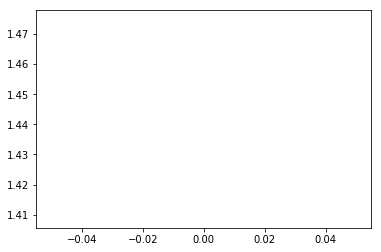

1m 43s (- 80m 20s) (210 2%) 1.2806
1m 43s (- 80m 20s) (210 2%) 1.3318
1m 48s (- 80m 9s) (220 2%) 1.3976
1m 48s (- 80m 10s) (220 2%) 1.2905
1m 52s (- 79m 56s) (230 2%) 1.3191
1m 52s (- 79m 56s) (230 2%) 1.2120
1m 57s (- 79m 45s) (240 2%) 1.3747
1m 57s (- 79m 45s) (240 2%) 1.2556
2m 2s (- 79m 33s) (250 2%) 1.3579
2m 2s (- 79m 33s) (250 2%) 1.2336
2m 7s (- 79m 33s) (260 2%) 1.2491
2m 7s (- 79m 33s) (260 2%) 1.2580
2m 12s (- 79m 24s) (270 2%) 1.2850
2m 12s (- 79m 24s) (270 2%) 1.2403
2m 16s (- 79m 14s) (280 2%) 1.2196
2m 16s (- 79m 14s) (280 2%) 1.3125
2m 21s (- 79m 9s) (290 2%) 1.3134
2m 21s (- 79m 9s) (290 2%) 1.2419
2m 26s (- 78m 59s) (300 3%) 1.1872
2m 26s (- 78m 59s) (300 3%) 1.2276
2m 31s (- 78m 59s) (310 3%) 1.3039
2m 31s (- 78m 59s) (310 3%) 1.2724
2m 36s (- 78m 48s) (320 3%) 1.4992
2m 36s (- 78m 48s) (320 3%) 1.3625
2m 41s (- 78m 41s) (330 3%) 1.2994
2m 41s (- 78m 41s) (330 3%) 1.3232
2m 45s (- 78m 33s) (340 3%) 1.2183
2m 45s (- 78m 33s) (340 3%) 1.2408
2m 50s (- 78m 18s) (350 3%)

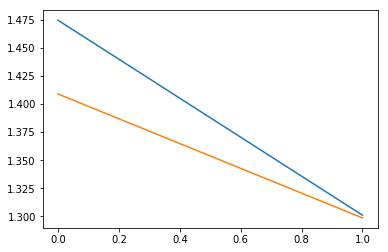

3m 21s (- 78m 26s) (410 4%) 1.2884
3m 21s (- 78m 27s) (410 4%) 1.1776
3m 25s (- 78m 18s) (420 4%) 1.1877
3m 25s (- 78m 18s) (420 4%) 1.2282
3m 30s (- 78m 6s) (430 4%) 1.3433
3m 30s (- 78m 6s) (430 4%) 1.2520
3m 35s (- 77m 58s) (440 4%) 1.2267
3m 35s (- 77m 58s) (440 4%) 1.1939
3m 40s (- 77m 57s) (450 4%) 1.2368
3m 40s (- 77m 57s) (450 4%) 1.1900
3m 45s (- 77m 50s) (460 4%) 1.2052
3m 45s (- 77m 50s) (460 4%) 1.1745
3m 49s (- 77m 42s) (470 4%) 1.1808
3m 49s (- 77m 42s) (470 4%) 1.2316
3m 54s (- 77m 36s) (480 4%) 1.2791
3m 54s (- 77m 36s) (480 4%) 1.2226
3m 59s (- 77m 28s) (490 4%) 1.3090
3m 59s (- 77m 28s) (490 4%) 1.2081
4m 4s (- 77m 28s) (500 5%) 1.2264
4m 4s (- 77m 28s) (500 5%) 1.3234
4m 9s (- 77m 19s) (510 5%) 1.2587
4m 9s (- 77m 19s) (510 5%) 1.1770
4m 14s (- 77m 13s) (520 5%) 1.2209
4m 14s (- 77m 13s) (520 5%) 1.1696
4m 18s (- 77m 6s) (530 5%) 1.2343
4m 18s (- 77m 6s) (530 5%) 1.2784
4m 23s (- 76m 59s) (540 5%) 1.2332
4m 23s (- 76m 59s) (540 5%) 1.3373
4m 28s (- 76m 54s) (550 5%) 

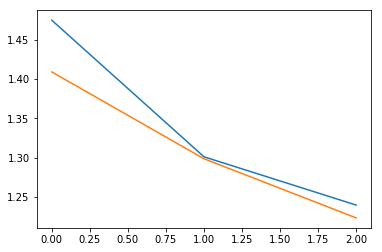

4m 58s (- 76m 36s) (610 6%) 1.2582
4m 58s (- 76m 36s) (610 6%) 1.2474
5m 3s (- 76m 28s) (620 6%) 1.1184
5m 3s (- 76m 28s) (620 6%) 1.2063
5m 8s (- 76m 21s) (630 6%) 1.2018
5m 8s (- 76m 21s) (630 6%) 1.1234
5m 12s (- 76m 11s) (640 6%) 1.2057
5m 12s (- 76m 11s) (640 6%) 1.1686
5m 17s (- 76m 1s) (650 6%) 1.2531
5m 17s (- 76m 1s) (650 6%) 1.2563
5m 21s (- 75m 53s) (660 6%) 1.1801
5m 21s (- 75m 53s) (660 6%) 1.1048
5m 26s (- 75m 46s) (670 6%) 1.2219
5m 26s (- 75m 46s) (670 6%) 1.2647
5m 31s (- 75m 41s) (680 6%) 1.3246
5m 31s (- 75m 41s) (680 6%) 1.2563
5m 36s (- 75m 39s) (690 6%) 1.4028
5m 36s (- 75m 39s) (690 6%) 1.2201
5m 41s (- 75m 32s) (700 7%) 1.2550
5m 41s (- 75m 32s) (700 7%) 1.2175
5m 45s (- 75m 24s) (710 7%) 1.2207
5m 45s (- 75m 24s) (710 7%) 1.2921
5m 50s (- 75m 14s) (720 7%) 1.1772
5m 50s (- 75m 14s) (720 7%) 1.1231
5m 54s (- 75m 5s) (730 7%) 1.1929
5m 54s (- 75m 5s) (730 7%) 1.2336
5m 59s (- 75m 1s) (740 7%) 1.2046
5m 59s (- 75m 1s) (740 7%) 1.1576
6m 4s (- 74m 52s) (750 7%) 1.1

In [18]:
trainIters(encoder1, decoder1,train_input, val_input, n_iters = 10000, print_every=10, plot_every=200, learning_rate=1e-3)
torch.save(encoder1.state_dict(), 'keywords_encoder.params')
torch.save(decoder1.state_dict(), 'keywords_attn_decoder1.params')

In [19]:
Doc.text_to_idxs("一万")

array([2])

In [20]:
a = {
                        "A": -1,
                        "B": -2,
                        "C": -3
                }

In [21]:
for k,v in a.items():
    a.update({k:v+len(a)})
a

{'A': 2, 'B': 1, 'C': 0}

In [22]:
# predict(Doc.text_to_idxs(np.array(["梦想"])))
predict(Doc.text_to_idxs("梦想希望"),encoder1,attn_decoder1)
#predict(Doc.text_to_idxs(),encoder1,attn_decoder1)

TypeError: object of type 'AttnDecoderRNN' has no len()